In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import QFT, IntegerComparator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

from lib.loss_tracker import *
from tqdm import trange

from dQA_circuit import HammingEvolution

In [2]:
# initializations
N_xi, N_features = 5, 7
csi_patterns = np.random.choice([1,-1], size=(N_xi, N_features))
labels = np.ones( (N_xi,) )

### Evolution

In [3]:
# circuit generator
qc_generator = HammingEvolution(num_data_qubits=N_features)

# actual circuit (in initial superposition)
qc = qc_generator.init_state_plus()

# track losses
loss_tracker = LossTracker(qc_generator.num_data_qubits,
                           qc_generator.num_ancillas,
                           init_state=qc)

In [4]:
# loop variables
P = 100
dt = 1

# start 'training'
for pp in trange(P):
    s_p = (pp+1)/P
    gamma_p = s_p*dt
    beta_p = (1-s_p)*dt

    for mu in range(N_xi):

        # create Hamming error counter circuit based on the given pattern
        qc_counter = qc_generator.Hamming_count(train_data=csi_patterns[mu,:])
        qc_counter_inverse = qc_counter.inverse()

        # create Uz evolution circuit
        qc_Uz = qc_generator.U_z(train_data=csi_patterns[mu,:], gamma=gamma_p)

        # compose all circuits to evolve according to Uz
        qc.compose(qc_counter, inplace=True)
        qc.compose(qc_Uz, inplace=True)
        qc.compose(qc_counter_inverse, inplace=True)

    # create and apply Ux evolution circuit
    qc_Ux = qc_generator.U_x(beta_p)
    qc.compose(qc_Ux, inplace=True)

    # measure loss
    loss_tracker.track( [qc_counter, qc_Uz, qc_counter_inverse, qc_Ux], compose=True)

100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


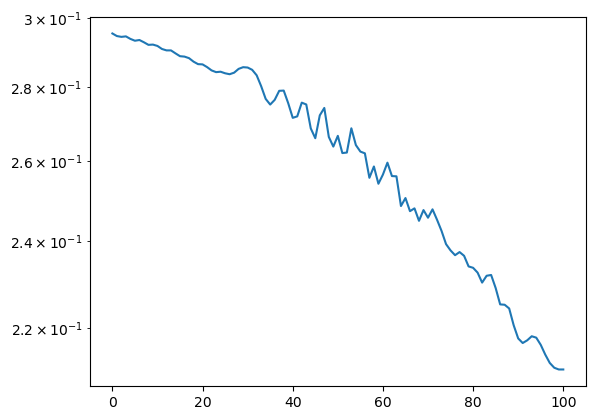

In [6]:
loss = np.real_if_close(loss_tracker.get_edensity(csi_patterns, little_endian=True))
plt.plot(loss)
plt.yscale('log')